# Deep Learning
# Assignment 7: Transformer

# Instructions
- Solve all the requirements and submit the notebooks with your answers and cell output.
- Don't forget to answer the required questions.
- Add comments to explain your code in detail.
- Before you submit your assignment, make sure everything runs as expected.

1- Use the provided dataset on this [link](https://github.com/Franck-Dernoncourt/pubmed-rct/tree/master/PubMed_200k_RCT_numbers_replaced_with_at_sign). Use the same assigned train, test and validation(dev) partitions \
2- **Preprocess** the dataset (Self Study)\
3- Use **Word Representation** method of your choice to get word embeddings for your text. Explain why you chose this method.\
3- You are required to **implement, train, and test a transformer** of your design to build a system that can classify each sentence in the abstract into the following classes: background, objective, method, result, or conclusion. **Print the model summary**.\
4- Plot the **training curves** (loss and accuracy) for the model.\
5- Plot the **confusion matrix** for the testing set and print the **performance metrics (test accuracy)**.\
6- **Comment** on the results and **explain** why you picked your choice of model architecture and hyperparameters\
7- **Use comments** to explain your code in detail. Ambiguity will result in losing grades.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
)

In [ ]:
# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Labels and mappings (PubMed 200k RCT style)

LABEL_NAMES = ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]
label2idx = {l: i for i, l in enumerate(LABEL_NAMES)}
idx2label = {i: l for l, i in label2idx.items()}

# Hyperparameters

MAX_VOCAB_SIZE = 30000    # Maximum vocabulary size built from training set
EMBED_DIM = 128           # Token embedding size
NUM_HEADS = 4             # Multi-head attention heads
NUM_LAYERS = 2            # Number of Transformer encoder layers
FF_DIM = 256              # Feed-forward hidden size inside Transformer
DROPOUT = 0.2             # Dropout for regularization
BATCH_SIZE = 64           # Mini-batch size
EPOCHS = 5                # Number of training epochs
LR = 2e-4                 # Learning rate for Adam

# Special tokens
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"



Using device: cuda


In [ ]:
DATA_DIR = "/content/drive/MyDrive/Transformer"
train_path = os.path.join(DATA_DIR, "train.txt")
dev_path = os.path.join(DATA_DIR, "dev.txt")
test_path = os.path.join(DATA_DIR, "test.txt")

In [ ]:
# Data loading utilities
def read_pubmed_file(path):
    """
    Read a PubMed 200k RCT-formatted file and return a list of samples.

    Each returned sample is a dict with:
      - "text": sentence text (string)
      - "label": label string (one of LABEL_NAMES)
      - "sent_idx": index of the sentence within its abstract (0-based)
      - "sent_total": total number of sentences in the abstract

    The original dataset is organized as abstracts separated by blank lines;
    each non-header line is "LABEL<TAB>SENTENCE". [web:5][web:8]
    """
    samples = []
    abstract = []  # temporary storage for sentences of the current abstract

    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")

            # Empty line signals end of an abstract
            if line == "":
                if abstract:
                    total = len(abstract)
                    # Convert sentences of this abstract into per-sentence samples
                    for idx, (label, text) in enumerate(abstract):
                        if label not in label2idx:
                            # Skip labels not in the 5-class label set
                            continue
                        samples.append(
                            {
                                "text": text,
                                "label": label,
                                "sent_idx": idx,
                                "sent_total": total,
                            }
                        )
                    abstract = []
                continue

            # Lines starting with "###" contain PMID metadata, not sentences
            if line.startswith("###"):
                continue

            # Sentence lines have the format: LABEL<TAB>SENTENCE
            parts = line.split("\t", 1)
            if len(parts) != 2:
                # Skip malformed lines
                continue
            label, text = parts
            abstract.append((label, text))

    # Flush last abstract in case file does not end with a blank line
    if abstract:
        total = len(abstract)
        for idx, (label, text) in enumerate(abstract):
            if label not in label2idx:
                continue
            samples.append(
                {
                    "text": text,
                    "label": label,
                    "sent_idx": idx,
                    "sent_total": total,
                }
            )

    return samples


In [ ]:
# Read train / dev / test samples from disk
train_samples = read_pubmed_file(train_path)
dev_samples = read_pubmed_file(dev_path)
test_samples = read_pubmed_file(test_path)

print("Train sentences:", len(train_samples))
print("Dev sentences:", len(dev_samples))
print("Test sentences:", len(test_samples))

Train sentences: 2211861
Dev sentences: 28932
Test sentences: 29493


In [ ]:
# Tokenization and vocabulary
def tokenize(text):
    """
    Simple regex-based tokenizer.

    - Lowercases the text
    - Splits into words and punctuation, keeping punctuation as separate tokens
      using the pattern: \w+ or any non-word, non-space character.
    """
    text = text.lower()
    tokens = re.findall(r"\w+|[^\w\s]", text)
    return tokens


# Build vocabulary only from training texts to avoid test leakage.
counter = Counter()
for s in train_samples:
    tokens = tokenize(s["text"])
    counter.update(tokens)

# Reserve 2 slots for PAD and UNK, then take most frequent tokens
most_common = counter.most_common(MAX_VOCAB_SIZE - 2)
itos = [PAD_TOKEN, UNK_TOKEN] + [w for w, _ in most_common]  # index-to-string
stoi = {w: i for i, w in enumerate(itos)}                    # string-to-index

PAD_ID = stoi[PAD_TOKEN]
UNK_ID = stoi[UNK_TOKEN]
VOCAB_SIZE = len(itos)
print("Vocab size:", VOCAB_SIZE)

<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3627794817.py:8: SyntaxWarning: invalid escape sequence '\w'
  using the pattern: \w+ or any non-word, non-space character.


Vocab size: 30000


In [ ]:
def numericalize(tokens):
    """
    Map tokens to integer IDs using the vocabulary; unseen tokens go to UNK_ID.
    """
    return [stoi.get(t, UNK_ID) for t in tokens]


In [ ]:
# Dataset and collate function
class PubMedDataset(Dataset):
    """
    Torch Dataset for sentence-level classification on PubMed RCT.

    Each item returns:
      - token_ids: 1D LongTensor of token IDs
      - label_id: scalar LongTensor for class index
      - pos_frac: scalar FloatTensor encoding sentence position in abstract:
                  sent_idx / (sent_total - 1) in [0, 1], or 0.0 if only 1 sentence.
    """

    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        # Tokenize and numericalize sentence text
        tokens = tokenize(s["text"])
        token_ids = numericalize(tokens)

        # Encode label as numeric ID
        label_id = label2idx[s["label"]]

        # Relative position of the sentence in its abstract
        if s["sent_total"] > 1:
            pos_frac = s["sent_idx"] / (s["sent_total"] - 1)
        else:
            pos_frac = 0.0

        return (
            torch.tensor(token_ids, dtype=torch.long),
            torch.tensor(label_id, dtype=torch.long),
            torch.tensor(pos_frac, dtype=torch.float),
        )


In [ ]:
def collate_batch(batch):
    """
    Collate function for DataLoader.

    - Pads variable-length token sequences in the batch to the same length
      using PAD_ID.
    - Stacks labels and position fractions.
    - Returns:
        padded_seqs:  LongTensor (batch, max_seq_len)
        lengths:      LongTensor (batch,) original sequence lengths
        pos_fracs:    FloatTensor (batch, 1) sentence position feature
        label_ids:    LongTensor (batch,) class indices
    """
    token_seqs, label_ids, pos_fracs = zip(*batch)

    # Original lengths before padding
    lengths = torch.tensor([len(s) for s in token_seqs], dtype=torch.long)

    # Pad sequences to the maximum length in the batch
    padded_seqs = pad_sequence(
        token_seqs,
        batch_first=True,
        padding_value=PAD_ID,
    )

    # Stack label IDs and position fractions
    label_ids = torch.stack(label_ids)
    pos_fracs = torch.stack(pos_fracs).unsqueeze(-1)  # (batch, 1)

    return padded_seqs, lengths, pos_fracs, label_ids

In [ ]:
# Instantiate datasets
train_ds = PubMedDataset(train_samples)
dev_ds = PubMedDataset(dev_samples)
test_ds = PubMedDataset(test_samples)

# DataLoaders with our custom collate_fn
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
)
dev_loader = DataLoader(
    dev_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
)

# Inspect one batch shape to verify pipeline
batch = next(iter(train_loader))
print("input_ids:", batch[0].shape)  # (batch, seq_len)
print("lengths:", batch[1].shape)    # (batch,)
print("pos_frac:", batch[2].shape)   # (batch, 1)
print("labels:", batch[3].shape)     # (batch,)

input_ids: torch.Size([64, 84])
lengths: torch.Size([64])
pos_frac: torch.Size([64, 1])
labels: torch.Size([64])


In [ ]:
# Positional encoding module
class PositionalEncoding(nn.Module):
    """
    Classic sinusoidal positional encoding.

    Precomputes a (max_len, embed_dim) matrix with sine/cosine patterns so that
    each position has a unique representation. This is added to token embeddings
    so the Transformer can use order information. [web:9][web:6]
    """

    def __init__(self, embed_dim, max_len=500):
        super().__init__()

        # pe: (max_len, embed_dim)
        pe = torch.zeros(max_len, embed_dim)

        # pos: (max_len, 1) representing position index
        pos = torch.arange(0, max_len).unsqueeze(1).float()

        # div: frequencies for sine/cosine across dimensions
        div = torch.exp(
            torch.arange(0, embed_dim, 2).float()
            * (-np.log(10000.0) / embed_dim)
        )

        # Apply sine to even dimensions, cosine to odd dimensions
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)

        # Shape: (1, max_len, embed_dim) to broadcast across batch dimension
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        """
        x: (batch, seq_len, embed_dim)

        Returns:
          x plus positional encodings for the first seq_len positions.
        """
        return x + self.pe[:, : x.size(1)].to(x.device)


I chose to learn word embeddings from scratch using my PubMed dataset. This means each word in the vocabulary is mapped to a dense vector that is initialized randomly and optimized along with the model during training.

**WHY?**
* Domain-Specific Vocabulary: Learning embeddings from scratch captures biomedical terms often missing in generic embeddings.

* Task-Specific Optimization: Embeddings are trained with the model, making them tailored for sentence classification.

* Integration with Transformers: Trainable embeddings work seamlessly with Transformer encoders and positional encodings.

In [ ]:
# Transformer-based sentence classifier
class TransformerClassifier(nn.Module):
    """
    Transformer encoder for sentence classification.

    Architecture:
      - Token embedding + sinusoidal positional encoding
      - TransformerEncoder with NUM_LAYERS encoder layers
      - Masked average pooling over non-padding tokens
      - Concatenation of sentence representation with sentence position feature
      - 2-layer MLP (128 hidden units) + dropout
      - Output logits over the 5 labels
    """

    def __init__(self, vocab_size, num_classes, pad_idx):
        super().__init__()

        self.pad_idx = pad_idx

        # Embedding layer with padding index so PAD tokens have fixed vector
        self.embedding = nn.Embedding(
            vocab_size,
            EMBED_DIM,
            padding_idx=pad_idx,
        )

        # Positional encoder adds position information to embeddings
        self.pos_encoder = PositionalEncoding(EMBED_DIM)

        # Single encoder layer definition for the Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM,
            nhead=NUM_HEADS,
            dim_feedforward=FF_DIM,
            dropout=0.1,
            batch_first=True,  # Input shape: (batch, seq_len, embed_dim)
            activation="gelu",
        )

        # Stack NUM_LAYERS encoder layers
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=NUM_LAYERS,
        )

        # After pooling, we concatenate:
        # - sentence representation (EMBED_DIM)
        # - position fraction (1)
        self.fc1 = nn.Linear(EMBED_DIM + 1, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, input_ids, lengths, pos_frac):
        """
        Forward pass.

        Args:
          input_ids: (batch, seq_len) LongTensor of token IDs
          lengths:   (batch,) LongTensor of actual sequence lengths
          pos_frac:  (batch, 1) FloatTensor of sentence position feature

        Returns:
          logits: (batch, num_classes) unnormalized class scores
        """
        # Build padding mask: True where tokens are PAD
        mask = input_ids == self.pad_idx  # (batch, seq_len), bool

        # Embed tokens and add positional encoding
        emb = self.embedding(input_ids)   # (batch, seq_len, EMBED_DIM)
        emb = self.pos_encoder(emb)       # (batch, seq_len, EMBED_DIM)

        # Apply Transformer encoder with padding mask
        enc_out = self.transformer(
            emb,
            src_key_padding_mask=mask,
        )  # (batch, seq_len, EMBED_DIM)

        # Masked average pooling over non-padding positions
        mask_float = (~mask).unsqueeze(-1).float()  # (batch, seq_len, 1)
        x_sum = (enc_out * mask_float).sum(dim=1)   # (batch, EMBED_DIM)
        lengths = lengths.unsqueeze(-1).float()     # (batch, 1)
        sent_repr = x_sum / lengths                 # (batch, EMBED_DIM)

        # Concatenate sentence representation with positional fraction
        h = torch.cat([sent_repr, pos_frac], dim=-1)  # (batch, EMBED_DIM+1)

        # MLP classifier with ReLU and dropout
        h = self.dropout(F.relu(self.fc1(h)))
        logits = self.fc2(h)

        return logits


In [ ]:
# Instantiate model and move to device
model = TransformerClassifier(
    vocab_size=VOCAB_SIZE,
    num_classes=len(LABEL_NAMES),
    pad_idx=PAD_ID,
).to(DEVICE)

print(model)

TransformerClassifier(
  (embedding): Embedding(30000, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=129, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Training

In [ ]:
# Training setup
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=1e-5,  # L2 regularization for better generalization
)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [ ]:
# Epoch runner (train / eval)
def run_epoch(loader, train=True):
    """
    Run one full pass over the given DataLoader.

    If train=True:
      - enables gradient computation
      - performs backprop and parameter updates

    Returns:
      avg_loss: average loss over all examples in loader
      avg_acc:  average accuracy over all examples in loader
    """
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.set_grad_enabled(train):
        for input_ids, lengths, pos_frac, labels in loader:
            input_ids = input_ids.to(DEVICE)
            lengths = lengths.to(DEVICE)
            pos_frac = pos_frac.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            logits = model(input_ids, lengths, pos_frac)
            loss = criterion(logits, labels)

            # Backward and optimization when training
            if train:
                optimizer.zero_grad()
                loss.backward()
                # Gradient clipping prevents exploding gradients in Transformers
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()

            # Compute batch accuracy
            preds = logits.argmax(dim=-1)  # predicted class indices
            correct = (preds == labels).sum().item()
            batch_size = labels.size(0)

            total_correct += correct
            total_count += batch_size
            total_loss += loss.item() * batch_size

    avg_loss = total_loss / total_count
    avg_acc = total_correct / total_count

    return avg_loss, avg_acc

In [ ]:
# Training loop
for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")

    # Train on training set
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    # Evaluate on validation set
    val_loss, val_acc = run_epoch(dev_loader, train=False)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f" Train loss: {tr_loss:.4f}, Train acc: {tr_acc:.4f}")
    print(f" Val loss:   {val_loss:.4f}, Val acc:   {val_acc:.4f}")

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


 Train loss: 0.3388, Train acc: 0.8741
 Val loss:   0.2647, Val acc:   0.8980
Epoch 2/5
 Train loss: 0.2761, Train acc: 0.8972
 Val loss:   0.2544, Val acc:   0.9027
Epoch 3/5
 Train loss: 0.2637, Train acc: 0.9012
 Val loss:   0.2438, Val acc:   0.9048
Epoch 4/5
 Train loss: 0.2559, Train acc: 0.9040
 Val loss:   0.2360, Val acc:   0.9083
Epoch 5/5
 Train loss: 0.2501, Train acc: 0.9063
 Val loss:   0.2323, Val acc:   0.9094


# Evaluaiton

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for input_ids, lengths, pos_frac, labels in test_loader:
        input_ids = input_ids.to(DEVICE)
        lengths = lengths.to(DEVICE)
        pos_frac = pos_frac.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(input_ids, lengths, pos_frac)
        preds = logits.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [ ]:
# classification report
print(
    classification_report(
        y_true,
        y_pred,
        target_names=LABEL_NAMES,
        digits=4,
    )
)

              precision    recall  f1-score   support

  BACKGROUND     0.7323    0.8137    0.7709      2663
   OBJECTIVE     0.7856    0.6630    0.7191      2377
     METHODS     0.9225    0.9706    0.9459      9751
     RESULTS     0.9525    0.9213    0.9366     10276
 CONCLUSIONS     0.9487    0.9282    0.9383      4426

    accuracy                         0.9081     29493
   macro avg     0.8683    0.8594    0.8622     29493
weighted avg     0.9087    0.9081    0.9075     29493



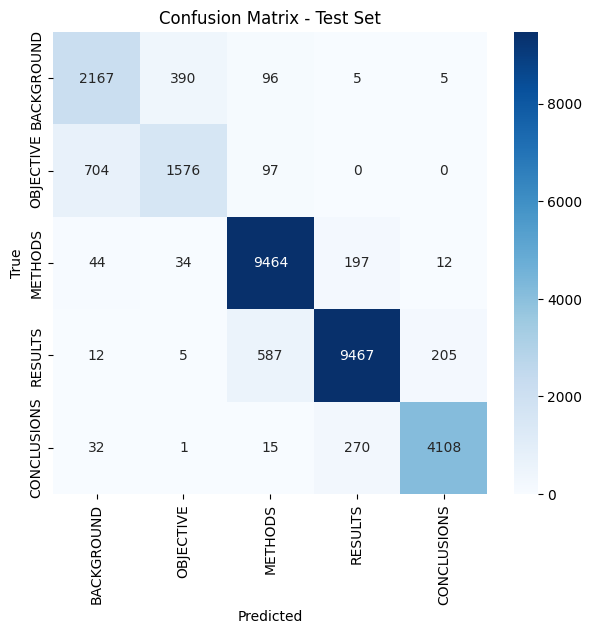

In [ ]:
# Confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=LABEL_NAMES,
    yticklabels=LABEL_NAMES,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

* The confusion matrix shows strong overall performance, with most predictions on the diagonal.

* Methods and Results are classified most accurately, while minor confusion occurs between semantically similar sections (Background ↔ Objective, Results ↔ Conclusions).

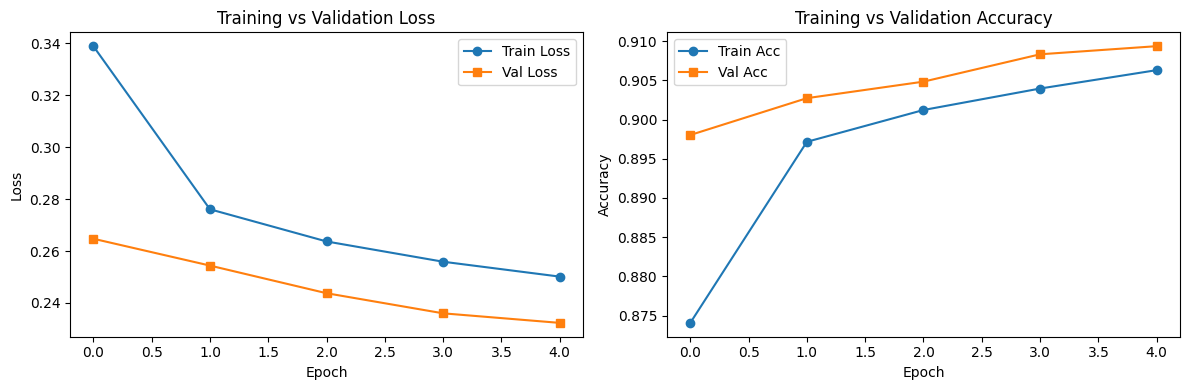

In [ ]:
# Training curves (loss and accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
ax1.plot(train_losses, label="Train Loss", marker="o")
ax1.plot(val_losses, label="Val Loss", marker="s")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Training vs Validation Loss")

# Accuracy curves
ax2.plot(train_accs, label="Train Acc", marker="o")
ax2.plot(val_accs, label="Val Acc", marker="s")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.set_title("Training vs Validation Accuracy")

plt.tight_layout()
plt.show()

* Training and validation loss steadily decrease, indicating stable learning.

* Training and validation accuracy consistently increase and remain close, showing good generalization with no overfitting.

The architecture is a small Transformer encoder with a position feature because the task is to classify single sentences in medical abstracts into 5 roles (background, objective, methods, results, conclusions), where both the words inside the sentence and its position in the abstract matter.​

**Model choice**

Transformer encoder, not RNN/CNN

* Sentences can be long and contain dependencies between distant words, so self-attention helps the model look at all words at once instead of step by step like an RNN.​

* A small Transformer (2 layers, 4 heads) is enough to capture these patterns while still being fast and not too heavy for this dataset.​

* Positional encoding + sentence position fraction

* Sinusoidal positional encoding lets the model understand the order of tokens in the sentence (who modifies whom, etc.).​

* The extra pos_frac feature encodes where the sentence is in the abstract (beginning, middle, end), which is strongly correlated with its label in PubMed 200k RCT; for example, background tends to appear at the start and conclusions at the end.​

**Hyperparameters choice**

Embedding size 128, FF 256, 4 heads, 2 layers

* These are “medium” sizes: big enough to learn useful patterns but small enough to train quickly and reduce overfitting on sentence-level classification.​

* More layers/heads would increase computation and risk overfitting without a huge gain for this relatively simple 5-class task.

Dropout 0.2, weight decay, LR = 2e-4

* Dropout and weight decay are used to regularize the model and improve generalization.​

* A relatively small learning rate (2e-4) is a safe choice for Transformers with Adam: it keeps training stable and avoids exploding loss.​

Batch size 64, 5 epochs

* Batch size 64 balances GPU memory and stable gradient estimates for this corpus of millions of sentences.​

* Training for 5 epochs is usually enough for a model of this size to converge on large text datasets without overfitting too much.​